In [1]:
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.position_estimation import derive_position
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants
from craterdetection.common.conics import *
from craterdetection.matching.utils import shift_nd

In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [3]:
resolution = (256, 256)

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 150

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2) * 1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

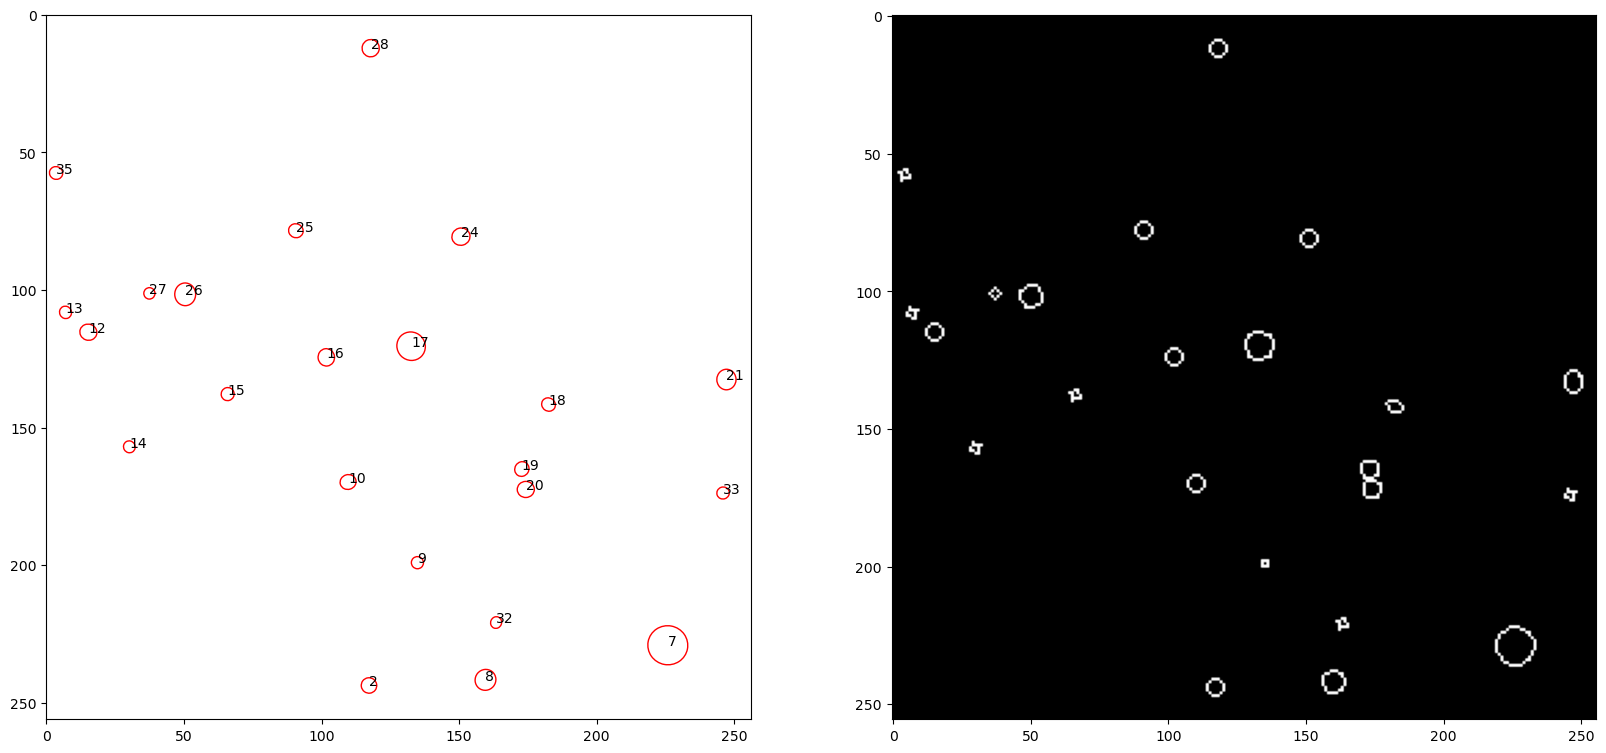

In [4]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = generate_mask(A_craters, resolution=resolution, instancing=False)

axes[1].imshow(img_ellipses, cmap='Greys_r')
fig.savefig('output/crater_mask_example.pdf', bbox_inches = 'tight', pad_inches = 0)

In [5]:
# db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], latlims=[40, 50], longlims=[40, 50], radius=100)
db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [6]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 10

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order], max_iter=max_iter)):

    diff = np.mean(np.abs(((db.features - features)/features)), axis=1)

    if np.min(diff) < max_diff:
        min_idx = np.argwhere(diff <= max_diff)

        subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad] \
                                                                         == db.get_position(min_idx)[0].T, axis=2)
        if np.logical_or.reduce(subset_match):
            print(f"MATCH [{i}]")
            match = min_idx[np.where(subset_match)].item()
            print(crater_triad)

            rank = np.where(np.sort(diff) == diff[match])[0].item()
            print(f"\tMean difference: {diff[match]:.2%}, position: "
                  f"{rank}")

            print("\tDetection feature: \t", features)
            print("\tDB match feature: \t", db.features[match])

            print("\tCrater triad coords: \t",
                  lat_cat[vicinity][detection_order][crater_triad],
                  long_cat[vicinity][detection_order][crater_triad])
            print("\tDB match coords: \t", *db.get_position(match))
            for detection_idx, db_idx in zip(crater_triad, db.crater_triads[match]):
                correct_matches[detection_idx] += [db_idx]
            print()

MATCH [0]
[0 1 2]
	Mean difference: 0.05%, position: 0
	Detection feature: 	 [ -10.173  -61.798  -60.887  -14.835  -57.032  -38.827 -244.834]
	DB match feature: 	 [ -10.17   -61.76   -60.867  -14.835  -57.015  -38.79  -244.609]
	Crater triad coords: 	 [0.788 0.786 0.774] [0.787 0.775 0.778]
	DB match coords: 	 [0.788 0.786 0.774] [0.787 0.775 0.778]

MATCH [1]
[5 4 3]
	Mean difference: 0.10%, position: 0
	Detection feature: 	 [ -23.027 -168.094 -208.7    -20.757 -127.599 -250.068 -878.989]
	DB match feature: 	 [ -23.022 -167.954 -208.25   -20.755 -127.45  -249.699 -877.807]
	Crater triad coords: 	 [0.775 0.781 0.799] [0.803 0.807 0.794]
	DB match coords: 	 [0.775 0.781 0.799] [0.803 0.807 0.794]

MATCH [2]
[6 7 8]
	Mean difference: 0.27%, position: 0
	Detection feature: 	 [ -157.624  -467.149  -461.273  -181.777  -423.381  -536.416 -2338.636]
	DB match feature: 	 [ -157.462  -465.902  -459.539  -181.627  -422.015  -534.596 -2328.553]
	Crater triad coords: 	 [0.799 0.782 0.773] [0.77  0

In [7]:
n_det = len(A_craters)
# Add noise
major_det, minor_det = ellipse_axes(A_craters)
psi_det = ellipse_angle(A_craters)
r_craters_det = conic_center(A_craters)

major_det += np.random.normal(scale=0.5, size=n_det)
minor_det += np.random.normal(scale=0.5, size=n_det)
psi_det += np.random.normal(scale=(10/180)*np.pi, size=n_det)
r_craters_det += np.random.normal(scale=1., size=r_craters_det.shape)

A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)

In [8]:
max_diff = 0.15
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1000
possible_matches = 0
db_tree = KDTree(db.features)

for crater_triad, features in CoplanarInvariants.match_generator(A_craters=A_craters_noisy, max_iter=max_iter):

    d, min_idx = db_tree.query(features, k=1, p=np.inf, workers=-1)

    subset_match = np.logical_and.reduce(lat_cat[vicinity][crater_triad] == db.get_position(min_idx)[0])
    # if np.logical_or.reduce(subset_match):
    match = min_idx

    diff = np.mean(np.abs(((db.features[min_idx] - features)/features)))
    if diff < max_diff:
        print(crater_triad)
        print(f"\tMean difference: {diff:.2%}")

        print("\tDetection feature: \t", features)
        print("\tDB match feature: \t", db.features[match])

        print("\tCrater triad coords: \t",
              lat_cat[vicinity][crater_triad],
              long_cat[vicinity][crater_triad])
        print("\tDB match coords: \t", *db.get_position(match))
        for detection_idx, db_idx in zip(crater_triad, db.crater_triads[match]):
            correct_matches[detection_idx] += [db_idx]
        print()
        possible_matches += 1
possible_matches

[7 6 8]
	Mean difference: 2.86%
	Detection feature: 	 [ -21.808 -301.355  -45.404  -41.412 -257.083  -29.468 -523.317]
	DB match feature: 	 [ -21.885 -277.741  -47.123  -40.981 -253.052  -30.159 -507.289]
	Crater triad coords: 	 [0.757 0.768 0.753] [0.823 0.839 0.798]
	DB match coords: 	 [0.757 0.768 0.753] [0.823 0.839 0.798]

[ 9 10 11]
	Mean difference: 5.70%
	Detection feature: 	 [  -71.274  -698.162 -1060.465   -59.117  -610.014 -1154.949 -3829.675]
	DB match feature: 	 [  -66.645  -634.974 -1085.204   -52.353  -602.453 -1234.169 -3733.875]
	Crater triad coords: 	 [0.765 0.774 0.772] [0.788 0.778 0.723]
	DB match coords: 	 [0.765 0.774 0.772] [0.788 0.778 0.723]

[17 16 15]
	Mean difference: 5.05%
	Detection feature: 	 [ -12.01   -41.922 -118.98   -14.818  -58.754  -69.56  -289.107]
	DB match feature: 	 [ -10.169  -42.933 -124.048  -14.836  -54.77   -71.015 -301.73 ]
	Crater triad coords: 	 [0.788 0.786 0.782] [0.787 0.775 0.761]
	DB match coords: 	 [0.788 0.786 0.782] [0.787 0.77

482

In [9]:
%%time
np.set_printoptions(precision=3)
max_diff = 0.05
top_n = 3
matches = {detection_key : [] for detection_key, _ in enumerate(A_craters_noisy)}
max_iter = 7140

db_tree = KDTree(db.features)

for crater_triad, features in CoplanarInvariants.match_generator(A_craters=A_craters_noisy, max_iter=max_iter):

    d, min_n = db_tree.query(features, k=top_n, workers=-1)
    diff = np.mean(np.abs(((db.features[min_n] - features)/features)), axis=1)

    possible_matches = diff <= max_diff

    min_n = min_n[possible_matches]
    diff = diff[possible_matches]
    # print(diff)
    if len(diff) > 0:
        for min_idx in min_n:
            for detection_idx, db_idx in zip(crater_triad, db.crater_triads[min_idx]):
                matches[detection_idx] += [db_idx]

Wall time: 2.74 s


In [13]:
%%time
batch_size = 10000
top_n = 5

match_threshold = 200

db_tree = KDTree(db.features)

matches = np.empty((batch_size, 3, 3))
top_n = [top_n] if top_n == 1 else top_n

crater_triads, features = next(CoplanarInvariants.match_generator(A_craters=A_craters, max_iter=max_iter, batch_size=batch_size))

d_n, min_n = db_tree.query(features, k=top_n, p=2, workers=-1)

derive_position()

Wall time: 69 ms


{0: (array([ 0,  4, 12, 15, 28]), array([1, 1, 1, 1, 1], dtype=int64)),
 1: (array([11,  1, 12]), array([3, 1, 1], dtype=int64)),
 2: (array([ 1,  2,  3, 16]), array([2, 1, 1, 1], dtype=int64)),
 3: (array([ 3, 23, 30]), array([2, 2, 1], dtype=int64)),
 4: (array([ 4,  6,  9, 11, 14]), array([1, 1, 1, 1, 1], dtype=int64)),
 5: (array([ 4,  5, 18, 24, 28]), array([1, 1, 1, 1, 1], dtype=int64)),
 6: (array([22, 29,  6]), array([2, 2, 1], dtype=int64)),
 7: (array([ 3,  7, 23]), array([2, 2, 1], dtype=int64)),
 8: (array([ 3,  6,  7,  8, 30]), array([1, 1, 1, 1, 1], dtype=int64)),
 9: (array([ 1,  9, 10, 25, 28]), array([1, 1, 1, 1, 1], dtype=int64)),
 10: (array([ 9, 10, 20, 21, 25]), array([1, 1, 1, 1, 1], dtype=int64)),
 11: (array([29, 11, 34]), array([3, 1, 1], dtype=int64)),
 12: (array([ 1,  6, 12, 14, 29]), array([1, 1, 1, 1, 1], dtype=int64)),
 13: (array([13, 35, 27]), array([2, 2, 1], dtype=int64)),
 14: (array([ 5, 14, 27, 29, 34]), array([1, 1, 1, 1, 1], dtype=int64)),
 15: (

In [12]:
np.unique(db.crater_triads)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
matches_val = dict()

for k, v in matches.items():
    if len(v) >= 2*top_n:
        match_idx, counts = np.unique(np.array(v), return_counts=True)
        ord = np.argsort(counts)
        if counts[ord][-1] > 5:
            print(k, match_idx[ord][-1].item())
            matches_val[k] = match_idx[ord][-1].item()

list(matches_val.values())
A_craters_det = A_craters_noisy[list(matches_val.keys())]
r_craters_det = db.r_craters[list(matches_val.values())]
C_craters_det = db.C_cat[list(matches_val.values())]

est_r = derive_position(A_craters_det, r_craters_det, C_craters_det, cam.T, cam.K())
print(f"Position error: {(LA.norm(cam.r.ravel() - est_r.ravel())):.2f} km")

In [ ]:
%%time
est_r = derive_position(*db.match_detections(A_craters_noisy, max_iter=200, threshold=0.05), cam.T, cam.K())
print(f"Position error: {(LA.norm(cam.r.ravel() - est_r.ravel())):.2f} km")

# MC Simulation

In [ ]:
latlims = (45, 60)
longlims = (45, 60)
diamlims = (2, 30)
ellipse_limit = 1.2
arclims = 0.5

triad_radius = 100

lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters(
        "../data/lunar_crater_database_robbins_2018.csv",
        latlims=latlims,
        longlims=longlims,
        diamlims=diamlims,
        ellipse_limit=ellipse_limit,
        arc_lims=arclims
    )
)
db = CraterDatabase(lat_cat, long_cat, major_cat, minor_cat, psi_cat, radius=triad_radius)

r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [ ]:
test_size = 10
resolution = (256, 256)

position_dataset = np.empty((test_size, 3, 1), np.float64)
attitude_dataset = np.empty((test_size, 3, 3), np.float64)

est_position_dataset = np.empty((test_size, 3, 1), np.float64)

position_noise = 2 #pixels
axis_noise = 1 #pixels
angle_noise = np.radians(20)

max_iter = 200
match_threshold = 0.01

for i in range(test_size):

    lat = np.random.uniform(*latlims)
    long = np.random.uniform(*longlims)
    cam_alt = np.random.uniform(150, 250)
    cam = Camera.from_coordinates(lat,
                                  long,
                                  cam_alt,
                                  convert_to_radians=True,
                                  resolution=resolution
                                  )

    # save cam.r, sol_incidence
    position_dataset[i] = cam.r

    # Rotations are incremental (order matters)
    cam.rotate('roll', np.random.uniform(0, 360))
    cam.rotate('pitch', np.random.uniform(-30, 30))
    cam.rotate('yaw', np.random.uniform(-30, 30))

    # save cam.T
    attitude_dataset[i] = cam.T

    visible = (cdist(r_craters_cat.squeeze(), cam.r.T) <= np.sqrt(2 * cam_alt * const.RMOON + cam_alt**2)).ravel()
    r_craters = r_craters_cat[visible]
    C_craters = C_craters_cat[visible]

    r_craters_img = cam.project_crater_centers(r_craters)
    in_image = np.logical_and.reduce(np.logical_and(r_craters_img > -20, r_craters_img < cam.resolution[0]+20), axis=1)

    r_craters = r_craters[in_image]
    C_craters = C_craters[in_image]

    A_craters = cam.project_crater_conics(C_craters, r_craters)
    n_det = len(A_craters)

    major_det, minor_det = ellipse_axes(A_craters)
    psi_det = ellipse_angle(A_craters)
    r_craters_det = conic_center(A_craters)

    major_det += np.random.uniform(-axis_noise, axis_noise, n_det)
    minor_det += np.random.uniform(-axis_noise, axis_noise, n_det)
    psi_det += np.random.uniform(-angle_noise, angle_noise, n_det)
    r_craters_det += np.random.uniform(-position_noise, position_noise, r_craters_det.shape)

    A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)
    if n_det >= 3:
        A_craters_det, r_craters_det, C_craters_det = db.match_detections(
                                                                  A_craters_noisy,
                                                                  max_iter=max_iter,
                                                                  threshold=match_threshold
                                                              )
        if len(A_craters_det) > 1:
            est_position_dataset[i] = derive_position(
                A_craters_det,
                r_craters_det,
                C_craters_det,
                cam.T,
                cam.K()
            )
        else:
            est_position_dataset[i] = np.ones((3,1))*-1
    else:
        est_position_dataset[i, ...] = -1

In [ ]:
matched_positions = (est_position_dataset[:,0,:] != -1).ravel()
est_position_dataset[matched_positions] - position_dataset[matched_positions]